# Dependencies

In [22]:
import tensorflow as tf
import numpy as np
from pyparsing import Word, alphas, nums, Suppress, Group, Optional, ZeroOrMore, ParseException, Forward, OneOrMore, ParseResults
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import csv


# Import Data

In [ ]:
# Mount drive and make folders

from google.colab import drive
drive.mount('/content/drive')

data_csv_path = '/content/drive/MyDrive/6.8301 Final Project/data/datasets/transcription/val.csv'

Mounted at /content/drive


In [ ]:
# Read CSV file
train_df = pd.read_csv(data_csv_path)

# Find the maximum sequence length in the 'visible_latex_chars' column
max_sequence_length = max(len(eval(seq)) for seq in train_df['visible_latex_chars'])

# Initialize an empty numpy arrays to store inputs
# xmins = np.zeros((len(train_df), max_sequence_length))
# xmaxs = np.zeros((len(train_df), max_sequence_length))
# ymins = np.zeros((len(train_df), max_sequence_length))
# ymaxs = np.zeros((len(train_df), max_sequence_length))

chars = []
xmins = []
xmaxs = []
ymins = []
ymaxs = []

# Iterate over each row in the DataFrame and unpack the string arrays for visible characters
for i, latex_string in enumerate(train_df['visible_latex_chars']):
    #split string into individual latex chars
    latex_string = latex_string.strip('[]')
    row_array = [element.strip("'") for element in latex_string.split(", ")]
    row = [element.replace('\\right)', ')').replace('\\left(', '(') for element in row_array]
    chars.append(row)

# Iterate over each row in the CSV and fill the numpy array
for i, row in enumerate(train_df['xmins']):
    # Parse the array from the string
    array_values = eval(row)
    xmins.append(array_values)

for i, row in enumerate(train_df['xmaxs']):
    # Parse the array from the string
    array_values = eval(row)
    xmaxs.append(array_values)

for i, row in enumerate(train_df['ymins']):
    # Parse the array from the string
    array_values = eval(row)
    ymins.append(array_values)

for i, row in enumerate(train_df['ymaxs']):
    # Parse the array from the string
    array_values = eval(row)
    ymaxs.append(array_values)


print(len(chars))
print(len(xmins))
print(len(xmaxs))
print(len(ymins))
print(len(ymaxs))

2000
2000
2000
2000
2000


# Filter for expressions which are a limit of fractions

In [ ]:
# Initialize an empty numpy arrays to store inputs
filtered_chars  = []
filtered_xmins = []
filtered_xmaxs = []
filtered_ymins = []
filtered_ymaxs = []

for i,row in enumerate(chars):
  if row[0].startswith('\\\\lim_') and '\\\\frac' in row and '\\\\right|' not in row and "\\\\sqrt":
    filtered_chars.append(row)
    filtered_xmins.append(xmins[i])
    filtered_xmaxs.append(xmaxs[i])
    filtered_ymins.append(ymins[i])
    filtered_ymaxs.append(ymaxs[i])

print(len(filtered_chars))
print(len(filtered_xmins))
print(len(filtered_xmaxs))
print(len(filtered_ymins))
print(len(filtered_ymaxs))

1287
1287
1287
1287
1287


# Separate input into limit, numerator, denominator

In [ ]:
def separate_input(visible_chars, xmins, xmaxs, ymins, ymaxs):
  #turn bounding boxes into arrays of arrays of floats
    xmins_floats = np.array(xmins, dtype=float)
    xmaxs_floats = np.array(xmaxs, dtype=float)
    ymins_floats = np.array(ymins, dtype=float)
    ymaxs_floats = np.array(ymaxs, dtype=float)

    lim_left = xmins_floats[0]
    lim_right = xmaxs_floats[0]
    lim_top = ymaxs_floats[0]
    lim_bottom = ymins_floats[0]
    frac_idx = visible_chars.index('\\\\frac')
    frac_bottom = ymaxs_floats[frac_idx]
    frac_top = ymins_floats[frac_idx]
    frac_left = xmins_floats[frac_idx]
    frac_right = xmaxs_floats[frac_idx]

    limits = [visible_chars[0]]
    numerators = []
    denominators = []
    for i in range(1, len(visible_chars)):
      if xmins_floats[i] >= frac_left-0.1 and ymins_floats[i] >= frac_top-0.1 and i != frac_idx:
        denominators.append(visible_chars[i])
      elif xmins_floats[i] >= frac_left-0.1 and ymaxs_floats[i] <= frac_bottom+0.1 and i != frac_idx:
        numerators.append(visible_chars[i])
      else:
        if xmaxs_floats[i] <= frac_left and i != frac_idx:
          limits.append(visible_chars[i])
    return limits,numerators,denominators



In [ ]:
limits = []
numerators = []
denominators = []
for i,row in enumerate(filtered_chars):
  limit,numerator,denominator = separate_input(row,filtered_xmins[i],filtered_xmaxs[i],filtered_ymins[i],filtered_ymaxs[i])
  joined_limit = ''.join(limit)
  print('limit',joined_limit)
  limits.append(limit)
  joined_numerator = ''.join(numerator)
  print('numerator',joined_numerator)
  numerators.append(joined_numerator)
  joined_denominator = ''.join(denominator)
  print('denominator',joined_denominator)
  denominators.append(joined_denominator)

print(len(limits))
print(len(numerators))
print(len(denominators))

limit \\lim_y\\to-2
numerator 2\(y-1\)\(y+4\)
denominator y+9
limit \\lim_h
numerator \\pi+\\frac23\\tanh
denominator \\to6
limit \\lim_s\\to\\pi
numerator 2s+\\sin3s
denominator /7\\sec9
limit \\lim_g\\to7+
numerator -8\\cosg\\sin2g
denominator \(7+0\\tang\)\\tan8g
limit \\lim_x\\to-1
numerator \\sin\(x+7\)
denominator x7+4x+14
limit \\lim_x\\to
numerator \\ln\(6+x9\)
denominator 3ex+-4\\sinx
limit \\lim_b\\to3
numerator eb6+0
denominator b+-6\\sinb
limit \\lim_b\\to
numerator \\tanb-4
denominator 2b
limit \\lim_t\\to\\infty
numerator 33t3+-t1+2
denominator \\sqrt18t3+t9+2
limit \\lim_a\\to5
numerator \\fracdda\(2+-4\\cos6a\)
denominator +\\fracdda\(\\sina+a\\cos3a\)
limit \\lim_z\\to
numerator \\frac2\\cosz+1\\secz
denominator 7z\\frac\\cosz
limit \\lim_x\\to2
numerator \(x5-87\)\(x7+47\)
denominator x-2
limit \\lim_w
numerator \\pi\\frac\\tan2w+\\sec7w2
denominator \\to9
limit \\lim_c\\to-\\infty4
numerator +108+\\tan7c2
denominator c\\fracc6
limit \\lim_b\\to
numerator \\cscb4
deno

# Turn Limits into Latex Strings

In [ ]:
parseable_limits = []
for limit in limits:
  latex_string = ''
  for elt in limit:
    if elt == '\\\\lim_':
      latex_string += '\lim_{'
    elif elt.startswith('\\\\'):
      elt_no_backslash = elt.replace('\\\\','\\')
      latex_string += elt_no_backslash
    else:
      latex_string += elt
  latex_string += '}'
  parseable_limits.append(latex_string)
print(parseable_limits)
print(len(parseable_limits))

['\\lim_{y\\to-2}', '\\lim_{h}', '\\lim_{s\\to\\pi}', '\\lim_{g\\to7+}', '\\lim_{x\\to-1}', '\\lim_{x\\to}', '\\lim_{b\\to3}', '\\lim_{b\\to}', '\\lim_{t\\to\\infty}', '\\lim_{a\\to5}', '\\lim_{z\\to}', '\\lim_{x\\to2}', '\\lim_{w}', '\\lim_{c\\to-\\infty4}', '\\lim_{b\\to}', '\\lim_{}', '\\lim_{h\\to-\\infty}', '\\lim_{b\\to5}', '\\lim_{x\\to\\infty}', '\\lim_{h\\to2\\(\\sinh+9\\)\\lim_{h}', '\\lim_{a}', '\\lim_{s\\to\\infty}', '\\lim_{w\\to}', '\\lim_{u\\to0}', '\\lim_{w\\to2}', '\\lim_{w\\to\\infty}', '\\lim_{b\\to\\pi/2}', '\\lim_{b\\to\\pi/}', '\\lim_{h\\to9}', '\\lim_{g\\to4t}', '\\lim_{y\\to2}', '\\lim_{v\\to}', '\\lim_{t\\to8}', '\\lim_{c\\to3}', '\\lim_{s\\to}', '\\lim_{s\\to3}', '\\lim_{x\\to\\infty}', '\\lim_{r\\to8+}', '\\lim_{s\\to\\infty}', '\\lim_{h\\to-2+}', '\\lim_{h\\to3}', '\\lim_{h\\to1-}', '\\lim_{p}', '\\lim_{\\theta}', '\\lim_{v\\to4}', '\\lim_{h\\to6+}', '\\lim_{k\\to2}', '\\lim_{h\\to}', '\\lim_{}', '\\lim_{h\\to\\infty}', '\\lim_{s}', '\\lim_{x\\to8}', '\\lim_

# Visualize Bounding Boxes


TypeError: Image data of dtype object cannot be converted to float

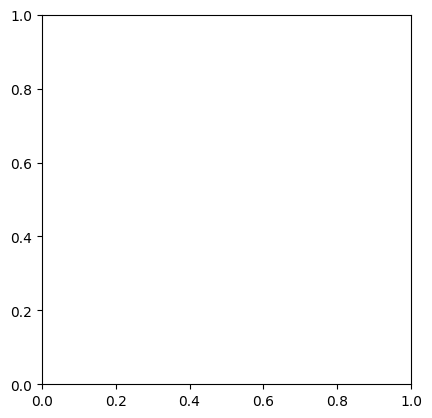

In [ ]:
xmins_floats = np.array(xmins[0], dtype=float)
xmaxs_floats = np.array(xmaxs[0], dtype=float)
ymins_floats = np.array(ymins[0], dtype=float)
ymaxs_floats = np.array(ymaxs[0], dtype=float)


img_path = '/content/drive/MyDrive/6.8301 Final Project/data/datasets/YOLO_data/images/train/79824ef7-c133-435d-b6d5-af6eca8d21ba.jpg'
image = cv2.imread(img_path)
plt.imshow(image)
plt.show()
height,width,_ = image.shape


# Plot the image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Get current axis
ax = plt.gca()

# Loop through bounding boxes and draw them on the image
for i in range(len(xmins_floats)):
  x = xmins_floats[i]
  y = ymins_floats[i]
  w = xmaxs_floats[i] - x
  h = ymaxs_floats[i] - y
  x1 = int(x * width)
  y1 = int(y * height)
  w1 = int(w * width)
  h1 = int(h * height)

  # Draw the bounding box
  rect = plt.Rectangle((x1, y1), w1, h1, linewidth=1, edgecolor='r', facecolor='none')
  ax.add_patch(rect)

# Show the plot
plt.show()


# Data Types to represent elements of calc expression

In [23]:
class limit:
    def __init__(self,var,max,expression):
        self.var = var
        self.max = max
        self.expression = expression

    def __str__(self):
        return '\lim_{'+self.var+'\to'+str(self.max)+'}'+str(self.expression)

class variable:
    def __init__(self,name):
        self.name = name

    def __str__(self):
        return self.name

class number:
    def __init__(self,value):
        self.value = value

    def __str__(self):
        return str(self.value)
class multiplication:
    def __init__(self,arr):
        self.arr = arr[:]

    def __str__(self):
        result = ''
        for elt in self.arr:
          result += str(elt)
        return result

class addition:
    def __init__(self,left,right):
        self.left = left
        self.right = right

    def __str__(self):
        return '({'+str(self.left)+'}+{'+str(self.right)+'})'

class subtraction:
    def __init__(self,left,right):
        self.left = left
        self.right = right

    def __str__(self):
        return '({'+str(self.left)+'}-{'+str(self.right)+'})'

class pi:
    def __init__(self):
        pass

    def __str__(self):
        return '\pi'

class sec:
  def __init__(self,x):
    self.x = x

  def __str__(self):
    return '\sec{('+str(self.x)+')}'

class csc:
  def __init__(self,x):
    self.x = x

  def __str__(self):
    return '\csc{('+str(self.x)+')}'

class tan:
  def __init__(self,x):
    self.x = x

  def __str__(self):
    return '\\tan{('+str(self.x)+')}'

class cot:
  def __init__(self,x):
    self.x = x

  def __str__(self):
    return '\\cot{('+str(self.x)+')}'

class cos:
  def __init__(self,x):
    self.x = x

  def __str__(self):
    return '\\cos{('+str(self.x)+')}'

class sin:
  def __init__(self,x):
    self.x = x

  def __str__(self):
    return '\\sin{('+str(self.x)+')}'

class infinity:
  def __init__(self):
    pass

  def __str__(self):
    return '\infty'



# Parse an expression


In [24]:
def parse_expression(str_expression):
    # Define tokens
    pi = Group(Suppress("\\pi")).set_results_name("pi")
    var = Group(Word(alphas, exact=1)).set_results_name("var")
    number = Group(Word(nums)).set_results_name("num")
    infty = Group(Suppress("\\infty")).set_results_name("infty")
    mult = Group(OneOrMore(pi | var | number)).set_results_name("mult")

    # Define expressions
    secant = Group(Suppress("\\sec") + Optional("(") + mult + Optional(")")).set_results_name("secant")
    cosecant = Group(Suppress("\\csc") + Optional("(") + mult + Optional(")")).set_results_name("cosecant")
    tangent = Group(Suppress("\\tan") + Optional("(") + mult + Optional(")")).set_results_name("tangent")
    cotangent = Group(Suppress("\\cot") + Optional("(") + mult + Optional(")")).set_results_name("cotangent")
    cosine = Group(Suppress("\\cos") + Optional("(") + mult + Optional(")")).set_results_name("cosine")
    sine = Group(Suppress("\\sin") + Optional("(") + mult + Optional(")")).set_results_name("sine")

    # Define value expression
    value = Group(pi | secant | cosecant | tangent | cotangent | cosine | sine | infty | mult).set_results_name("value")

    # Define expressions for addition and subtraction
    add = Group(Optional("(") + value + "+" + value + Optional(")")).set_results_name("add")
    sub = Group(Optional("(") + value + "-" + value + Optional(")")).set_results_name("sub")

   # Define expression combining all the expressions
    expression = Group(Optional("(") + (add | sub | value) + Optional(")")).set_results_name("expression")

    # Parse the expression
    result = expression.parseString(str_expression)

    return result


# Test parsing
test_input = "x + \\tan3y"
try:
    result = parse_expression(test_input)
    print("Parsing successful!")
    print("Result:", result.asList())
except Exception as e:
    print("Parsing failed:", e)


# Function to recursively print names of items in ParseResults
def print_names(result):
    for item in result:
        if isinstance(item, ParseResults):
          print(item.get_name(),item)
          print_names(item)
        else:
          print(item)

# Assuming result is your ParseResults object
print_names(result)


Parsing successful!
Result: [[[[[['x']]], '+', [[[['3'], ['y']]]]]]]
expression [[[[['x']]], '+', [[[['3'], ['y']]]]]]
add [[[['x']]], '+', [[[['3'], ['y']]]]]
value [[['x']]]
mult [['x']]
var ['x']
x
+
value [[[['3'], ['y']]]]
tangent [[['3'], ['y']]]
mult [['3'], ['y']]
num ['3']
3
var ['y']
y


# Turn parsed expression into data type

In [25]:
def make_abstract_syntax_tree(parse_result):
  if(parse_result.getName() == "expression"):
    exp_no_paren = [elt for elt in parse_result if elt != ')' and elt != '('] #must be either value, add, or sub
    item_name = exp_no_paren[0].getName()
    if(item_name == "add"):
      return make_abstract_syntax_tree(exp_no_paren[0])
    elif(item_name == "sub"):
      return make_abstract_syntax_tree(exp_no_paren[0])
    elif(item_name == "value"):
      return make_abstract_syntax_tree(exp_no_paren[0])
    else:
      raise Exception("Invalid expression")
  elif (parse_result.getName() == "value"):
    item = parse_result[0]
    if(item.getName() == "pi"):
      return pi()
    elif(item.getName() == "var"):
      return variable(item[0])
    elif(item.getName() == "num"):
      return number(item[0])
    elif(item.getName() == "infty"):
      return infinity()
    else:
      return make_abstract_syntax_tree(item)
  elif (parse_result.getName() == "add"):
    add_no_paren = [elt for elt in parse_result if elt != ')' and elt != '(']
    left = make_abstract_syntax_tree(add_no_paren[0])
    right = make_abstract_syntax_tree(add_no_paren[2])
    return addition(left,right)
  elif (parse_result.getName() == "sub"):
    sub_no_paren = [elt for elt in parse_result if elt != ')' and elt != '(']
    left = make_abstract_syntax_tree(sub_no_paren[0])
    right = make_abstract_syntax_tree(sub_no_paren[2])
    return subtraction(left,right)
  elif (parse_result.getName() == "secant"):
    secant_no_paren = [elt for elt in parse_result if elt != ')' and elt != '(']
    geo_exp = make_abstract_syntax_tree(secant_no_paren[0])
    return sec(geo_exp)
  elif(parse_result.getName() == "cosecant"):
    cosecant_no_paren = [elt for elt in parse_result if elt != ')'and elt != '(']
    geo_exp = make_abstract_syntax_tree(cosecant_no_paren[0])
    return csc(geo_exp)
  elif(parse_result.getName() == "tangent"):
    tangent_no_paren = [elt for elt in parse_result if elt != ')' and elt != '(']
    geo_exp = make_abstract_syntax_tree(tangent_no_paren[0])
    return tan(geo_exp)
  elif(parse_result.getName() == "cotangent"):
    cotangent_no_paren = [elt for elt in parse_result if elt != ')' and elt != '(']
    geo_exp = make_abstract_syntax_tree(cotangent_no_paren[0])
    return cot(geo_exp)
  elif (parse_result.getName() == "cosine"):
    cosine_no_paren = [elt for elt in parse_result if elt != ')' and elt != '(']
    geo_exp = make_abstract_syntax_tree(cosine_no_paren[0])
    return cos(geo_exp)
  elif (parse_result.getName() == "sine"):
    sine_no_paren = [elt for elt in parse_result if elt != ')' and elt != '(']
    geo_exp = make_abstract_syntax_tree(sine_no_paren[0])
    return sin
  elif(parse_result.getName() == "mult"):
    mult_arr = []
    for elt in parse_result:
      mult_arr.append(make_abstract_syntax_tree(elt))
    return multiplication(mult_arr)
  elif(parse_result.getName() == "infty"):
    return infinity()
  elif(parse_result.getName() == "pi"):
    return pi()
  elif(parse_result.getName() == "var"):
    return  variable(parse_result[0])
  elif(parse_result.getName() == "num"):
    return number(parse_result[0])
  else:
    raise Exception("Invalid expression", parse_result.asList())

# Parser Tests

In [ ]:
# Function to recursively print names of items in ParseResults
def print_names(result):
  for item in result:
      if isinstance(item, ParseResults):
        print(item.get_name(),item)
        print_names(item)
      else:
        print(item)


# # Test parsing
# test_input1 = "x"
# try:
#     result1 = parse_expression(test_input1)
#     print("Parsing successful!")
#     print("Result:", result1.asList())
# except Exception as e:
#     print("Parsing failed:", e)

# print_names(result1)

# #testing make syntax tree
# AST1 = make_abstract_syntax_tree(result1[0])
# print(type(AST1))
# print(str(AST1))

# # Test parsing
# test_input2 = "x + 2"
# try:
#     result2 = parse_expression(test_input2)
#     print("Parsing successful!")
#     print("Result:", result2.asList())
# except Exception as e:
#     print("Parsing failed:", e)

# print_names(result2)

# #testing make syntax tree
# AST2 = make_abstract_syntax_tree(result2[0])
# print(type(AST2))
# print(str(AST2))


# Test parsing
test_input3 = "e-3h"
try:
    result3 = parse_expression(test_input3)
    print("Parsing successful!")
    print("Result:", result3.asList())
except Exception as e:
    print("Parsing failed:", e)

print_names(result3)

#testing make syntax tree
AST3 = make_abstract_syntax_tree(result3[0])
print(type(AST3))
print(str(AST3))


Parsing successful!
Result: [[[[[['e']]], '-', [[['3'], ['h']]]]]]
expression [[[[['e']]], '-', [[['3'], ['h']]]]]
sub [[[['e']]], '-', [[['3'], ['h']]]]
value [[['e']]]
mult [['e']]
var ['e']
e
-
value [[['3'], ['h']]]
mult [['3'], ['h']]
num ['3']
3
var ['h']
h
<class '__main__.subtraction'>
({e}-{3h})


# Turn numerators and denominators into parseable latex strings

In [26]:
parseable_denominators = []
for i,denom in enumerate(denominators):
  try:
    parsed = parse_expression(denom)
    AST_denom = make_abstract_syntax_tree(parsed[0])
    parseable_denominators.append(str(AST_denom))
  except Exception as e:
    parseable_denominators.append(None)
print('denoms',parseable_denominators)
print('len denoms', len(parseable_denominators))
sum_none = sum(1 for item in parseable_denominators if item is None)
print('denom nones',sum_none)


parseable_numerators = []
for i,num in enumerate(numerators):
  try:
    parsed = parse_expression(num)
    AST_num = make_abstract_syntax_tree(parsed[0])
    parseable_numerators.append(str(AST_num))
  except Exception as e:
    parseable_numerators.append(None)
print('nums', parseable_numerators)
print('len nums', len(parseable_numerators))
sum_none = sum(1 for item in parseable_numerators if item is None)
print('num nones',sum_none)



denoms ['({y}+{9})', None, None, None, '({x7}+{4x})', '3ex', 'b', '2b', None, None, '7z', '({x}-{2})', None, 'c', '8b', None, '({e}-{3h})', None, '9', None, None, '6s', '4', None, None, None, None, '37', 'h', 'g', 'y', '8e', '2', None, '2s2', 's', '({6x}+{8})', '({7}+{8r})', 'e24s', '({h}+{3})', None, '({h}-{h})', None, None, None, '({9}+{3h})', None, '64', 't', None, None, 'x', None, None, None, '2v0', 'x', None, 's', None, 'c8', None, '3', 'u', None, None, '({2w2}-{2})', 'w2', 'u', None, '9', 'b7', '6', None, None, None, None, None, 'g', None, '({1v2}-{3})', '87', 'x', '2t2', 'w', None, '9', 'u', None, 'n2', None, 'v', None, '3', '2v', None, '65', '91', '({z}-{9})', None, '6x', None, '({95t}+{1})', '2', None, None, None, 'e22y', None, None, '11n3', '({x}+{1})', None, None, None, '({g}+{2})', None, 'p', None, 'y', 'w', None, '5k4', 'a', None, '({z}-{2})', 'y', '({4g}-{6})', '3', 'b3', 'w', '({r}-{8})', 'x', None, None, '6t', None, None, 'g', 'v', 'r', '0', None, None, None, 's', None,

Piece together limit, numerator, and denominator


In [27]:
latex_strings = []
for i in range(len(parseable_limits)):
  if(parseable_denominators[i] is not None and parseable_numerators[i] is not None):
    latex_string = parseable_limits[i]
    latex_string += '\\frac{'+parseable_numerators[i]+'}{'+parseable_denominators[i]+'}'
    latex_strings.append(latex_string)
    print(latex_string)
print(len(latex_strings))
np_latex_strings = np.array(latex_strings)

\lim_{y\to-2}\frac{2}{({y}+{9})}
\lim_{b\to3}\frac{({eb6}+{0})}{b}
\lim_{h\to-\infty}\frac{h2}{({e}-{3h})}
\lim_{s\to\infty}\frac{s3}{6s}
\lim_{w\to}\frac{8}{4}
\lim_{b\to\pi/}\frac{9}{37}
\lim_{g\to4t}\frac{({g}+{4t})}{g}
\lim_{v\to}\frac{({3v2}-{2v})}{8e}
\lim_{t\to8}\frac{2t}{2}
\lim_{s\to}\frac{({s}+{4})}{2s2}
\lim_{s\to3}\frac{2}{s}
\lim_{x\to\infty}\frac{({8x}-{8x})}{({6x}+{8})}
\lim_{s\to\infty}\frac{8}{e24s}
\lim_{h\to-2+}\frac{({h}-{1})}{({h}+{3})}
\lim_{h\to1-}\frac{({1}+{2h})}{({h}-{h})}
\lim_{h\to}\frac{9}{64}
\lim_{x\to8}\frac{9}{x}
\lim_{v\to}\frac{1ev}{2v0}
\lim_{x\to8+\cotx+-8}\frac{2}{x}
\lim_{c\to-\infty}\frac{c0}{c8}
\lim_{k\to-\infty}\frac{7}{3}
\lim_{w\to\infty}\frac{({2w}+{7})}{({2w2}-{2})}
\lim_{w\to5}\frac{1}{w2}
\lim_{b\to2--}\frac{({7b}-{8})}{b7}
\lim_{g\to\infty}\frac{g8}{g}
\lim_{v\to-\infty}\frac{({6v}+{4})}{({1v2}-{3})}
\lim_{x\to\infty}\frac{4x}{x}
\lim_{t\to\infty}\frac{15t6}{2t2}
\lim_{w\to9}\frac{t}{w}
\lim_{s\to\infty}\frac{e4}{9}
\lim_{n\to2}\frac{2}

# Save Strings to a CSV File



In [28]:
# Write array to a CSV file
csv_file_path = '/content/drive/MyDrive/6.8301 Final Project/latex_strings.csv'
with open(csv_file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for item in latex_strings:
        writer.writerow([item])